# Ornstein Uhlenbeck process

The SDE is
$$dX_t = \alpha(\beta - X_t) dt + \sigma dW_t$$
We will fix it at $\alpha=1.0$, $\beta=0$ and $\sigma=1$, i.e.
$$dX_t = - X_t dt + dW_t$$
as this corresponds to the 0.5 exponent version of the 1D Matern SPDE with $\kappa=\alpha^{-1} = 1.0$
$$(\kappa^2 - \Delta)^\frac{1}{2}X_t = \mathcal{W}$$.

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, solve_triangular
import networkx as nx
from graphite_maps.precision_estimation import fit_precision_cholesky, precision_to_graph

In [2]:
def rXt_ou_euler(n, p, dt, alpha=1.0, beta=0, sigma=1):
    # Initialize the result matrix (n x p) with zeros
    xt = np.zeros((n, p))
    
    # Simulate from limiting stationary distribution: N(beta, sigma^2/(2*alpha))
    x0 = norm.rvs(loc=beta, scale=sigma / np.sqrt(2 * alpha), size=n)
    
    # Set the initial condition for the first time step
    xt[:, 0] = x0
    
    # Simulate sample paths according to the Euler scheme
    for i in range(n):
        # Generate random normal increments dW
        dW = norm.rvs(loc=0, scale=np.sqrt(dt), size=p-1)
        for j in range(1, p):
            xt[i, j] = xt[i, j-1] + alpha * (beta - xt[i, j-1]) * dt + sigma * dW[j-1]
    
    return xt

In [3]:
# Fix parameters and simulate the process
alpha = 1.0
beta = 0.0
sigma = 1.0
n = 100
p = 100
T = 10
dt = T / p

In [4]:
time = np.arange(0, T, dt)
U = rXt_ou_euler(n, p, dt, alpha=alpha, beta=beta, sigma=sigma)

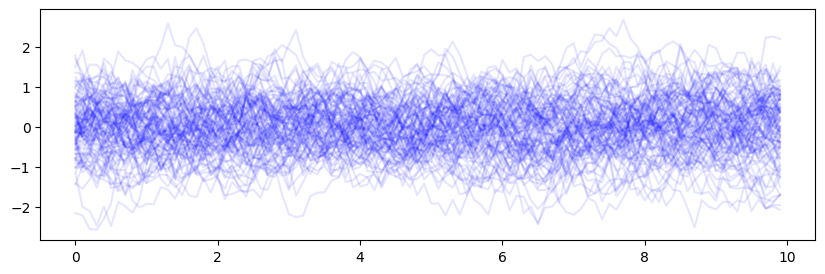

In [5]:
plt.figure(figsize=(10, 3))
for i in range(n):
    plt.plot(time, U[i, :], color='blue', alpha=0.1)
plt.show()

## Multivariate Gaussian Kullback-Leibler Divergence

Our objective is to measure $KLD(P|Q)$, where $P$ is the true distribution that MC is sampled from. In our case it will be the implicit from the Euler scheme. We will make it explicit later.

In [6]:
def logdet_cholesky(A):
    L = cho_factor(A, lower=True)[0]
    logdet = 2 * np.sum(np.log(np.diag(L)))
    return logdet

def kldiv_mvn_cholesky(mu1, Sigma1, mu2, Sigma2):
    """
    Compute the Kullback-Leibler divergence between two multivariate normal distributions
    using Cholesky decomposition for numerically stable log-determinant computation.

    See https://statproofbook.github.io/P/mvn-kl.html for MVN KLD computation.
    
    Parameters:
    - mu1: Mean vector of the first distribution (numpy array)
    - Sigma1: Covariance matrix of the first distribution (numpy array)
    - mu2: Mean vector of the second distribution (numpy array)
    - Sigma2: Covariance matrix of the second distribution (numpy array)
    
    Returns:
    - KLD: The Kullback-Leibler divergence (scalar)
    """
    
    # Difference in means
    diff_mu = mu2 - mu1
    
    # Inverse of Sigma2 using Cholesky decomposition
    Sigma2_chol = cho_factor(Sigma2, lower=True)
    Sigma2_inv_mu_diff = cho_solve(Sigma2_chol, diff_mu)
    
    # Mahalanobis distance between the means
    mahalanobis_term = np.dot(diff_mu.T, Sigma2_inv_mu_diff)
    
    # Trace of Sigma2_inv * Sigma1
    Sigma2_inv_Sigma1 = cho_solve(Sigma2_chol, Sigma1)
    tr_term = np.trace(Sigma2_inv_Sigma1)
    
    # Log determinant terms using Cholesky-based logdet calculation
    logdet_Sigma1 = logdet_cholesky(Sigma1)
    logdet_Sigma2 = logdet_cholesky(Sigma2)
    
    # Dimensionality of the mean vectors
    d = len(mu1)
    
    # Final KLD formula
    kld = 0.5 * (mahalanobis_term + tr_term - logdet_Sigma1 + logdet_Sigma2 - d) / d
    
    return kld


## Ensemble Data Assimilation definitions of $Q$

In [1]:
# Correct covariance function for Matern SPDE with nu=1/2
def cov_stationary(h):
    # ou: dx = alpha(beta - x)dt + sigma dW_t -- dx = -\alpha x dt + dW
    # matern: (kappa**2 - Delta)**(1/2) x = W -- (1.0**2 - Delta)**(1/2) x = W
    # sigma_matern = sigma_ou / (2 * alpha_ou)
    # kappa_matern = alpha_ou^{-1} = 1.0
    return np.exp(-np.abs(h)) / 2.0

def cov_matrix_matern(grid):
    p = len(grid)
    cov_matrix = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            cov_matrix[i,j] = cov_stationary(grid[j] - grid[i])
    return cov_matrix

In [8]:
def Q_ensemble_smoother(U):
    mu = U.mean(axis=0)
    cov_sample = np.cov(U,rowvar=False)
    return mu, cov_sample

def create_ar_graph(p):
    G = nx.Graph()
    # vertices
    for i in range(p):
        # edges
        G.add_node(i)
        # vertices
        for j in range(i+1, min(i + 1 + 1, p)):
            G.add_edge(i, j)
    return G

def Q_ensemble_information_filter(U, G):
    mu = U.mean(axis=0)
    prec_est, Graph_C, perm_compose, P_rev, P_order = fit_precision_cholesky(U, G, verbose_level=0)
    cov = np.linalg.inv(prec_est.A)
    return mu, cov

def Q_euler_scheme_ou(p, dt):
    # corresponds to AR-1
    mu = np.zeros(p)
    phi = 1.0 - 1.0*dt # generally 1.0 - alpha * dt
    prec_ar = sp.sparse.diags(
        [np.repeat(-phi, p-1), np.concatenate(([1.0], np.repeat(1.0+phi**2, p-2), [1.0])), np.repeat(-phi, p-1)], 
        [-1,0,1], shape=(p, p), 
        format='csc'
    )
    cov = np.linalg.inv(prec_ar.A) * dt
    return mu, cov
    

def Q_analytical_ou(grid):
    p = len(grid)
    mu = np.zeros(p)
    cov = cov_matrix_matern(grid)
    return mu, cov

In [9]:
G_u = create_ar_graph(p)
Q_ensemble_information_filter(U, G_u)

/Users/BERL/Github/venv_sksparse/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Learning precision Cholesky factor row-by-row: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2269.83it/s]


(array([ 0.02389472,  0.02886049,  0.04354021,  0.04023758,  0.02255022,
         0.004145  , -0.01716251, -0.04025171, -0.0426911 , -0.05246737,
        -0.03613722,  0.06602448,  0.02553205,  0.02809058, -0.03075691,
         0.03014555,  0.00404249,  0.00511964,  0.02626209,  0.0239283 ,
         0.00357538, -0.02545505, -0.00841951,  0.00932946,  0.02725741,
         0.08879465,  0.12017815,  0.01868041,  0.06307915,  0.04000015,
        -0.01004616,  0.06823296,  0.11946754,  0.11812198,  0.09287644,
         0.07666829,  0.0652357 ,  0.12112746,  0.08490269,  0.07233118,
         0.10386232,  0.06295038,  0.00627246, -0.01959196, -0.05168619,
        -0.05340251, -0.09946664, -0.06244345, -0.0179765 , -0.00017086,
         0.06476491,  0.04547115,  0.0454811 ,  0.03786827,  0.04930943,
         0.00018448, -0.04360765,  0.01457127,  0.04119614,  0.06969704,
         0.01659439, -0.06084458, -0.09021492, -0.10840291, -0.0770651 ,
        -0.11149716, -0.08569252, -0.11083656, -0.0

In [10]:
Q_euler_scheme_ou(p, dt)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[5.26315789e-01, 4.73684211e-01, 4.26315789e-01, ...,
         1.91765207e-05, 1.72588687e-05, 1.55329818e-05],
        [4.73684211e-01, 5.26315789e-01, 4.73684211e-01, ...,
         2.13072453e-05, 1.91765207e-05, 1.72588687e-05],
        [4.26315789e-01, 4.73684211e-01, 5.26315789e-01, ...,
         2.36747170e-05, 2.13072453e-05, 1.91765207e-05],
        ...,
        [1.91765207e-05, 2.13072453e-05, 2.36747170e-05, ...,
         5.26315789e-01, 4.73684211e-01, 4.26315789e-01],
        [1.72588687e-05, 1.91765207e-05, 2.13072453e-05, 

# Increasing Resolution experiment

In [19]:
# Fix parameters and simulate the process
alpha = 1.0
beta = 0.0
sigma = 1.0
n = 1000
#p = 100
resolutions = np.arange(10,401,10)
T = 10

In [20]:
n_resolutions = len(resolutions)
kld_euler, kld_enif, kld_enkf = np.zeros(n_resolutions), np.zeros(n_resolutions), np.zeros(n_resolutions)
for i, p in enumerate(resolutions):
    # Simulate process using the Euler scheme
    dt = T / p
    time = np.arange(0, T, dt)
    U = rXt_ou_euler(n, p, dt, alpha=alpha, beta=beta, sigma=sigma)

    # Determine the Q-approximate distribution
    # euler
    mu_euler, cov_euler = Q_euler_scheme_ou(p, dt)
    # enif
    G_u = create_ar_graph(p)
    mu_enif, cov_enif = Q_ensemble_information_filter(U, G_u)
    # enkf
    mu_es, cov_es = Q_ensemble_smoother(U)

    # Compute KLD to analytical solution
    mu_analytical, cov_analytical = Q_analytical_ou(time)
    kld_euler[i] = kldiv_mvn_cholesky(mu_analytical, cov_analytical, mu_euler, cov_euler)
    kld_enif[i] = kldiv_mvn_cholesky(mu_analytical, cov_analytical, mu_enif, cov_enif)
    kld_enkf[i] = kldiv_mvn_cholesky(mu_analytical, cov_analytical, mu_es, cov_es)

Learning precision Cholesky factor row-by-row: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 1367.95it/s]


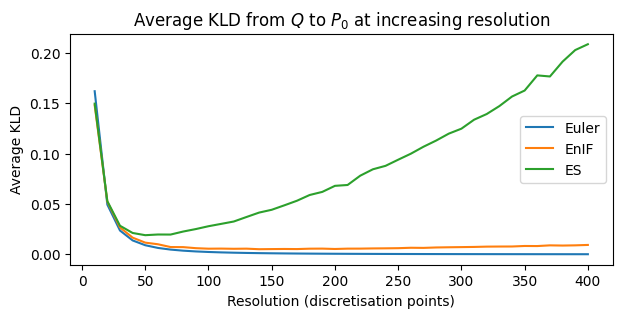

In [22]:
plt.figure(figsize=(7, 3))
plt.plot(resolutions, kld_euler, label="Euler")
plt.plot(resolutions, kld_enif, label="EnIF")
plt.plot(resolutions, kld_enkf, label="ES")

plt.xlabel('Resolution (discretisation points)')
plt.ylabel('Average KLD')
plt.title('Average KLD from $Q$ to $P_0$ at increasing resolution')
plt.legend()

#plt.yscale("log")

if True:
    plt.savefig("kld_average_vs_resolution.pdf", format='pdf', bbox_inches='tight')

plt.show()
plt.close()

In [47]:
kld_euler

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
cov_analytical

array([[1.        , 0.9875778 , 0.97530991, ..., 0.00699542, 0.00690852,
        0.0068227 ],
       [0.9875778 , 1.        , 0.9875778 , ..., 0.00708341, 0.00699542,
        0.00690852],
       [0.97530991, 0.9875778 , 1.        , ..., 0.00717251, 0.00708341,
        0.00699542],
       ...,
       [0.00699542, 0.00708341, 0.00717251, ..., 1.        , 0.9875778 ,
        0.97530991],
       [0.00690852, 0.00699542, 0.00708341, ..., 0.9875778 , 1.        ,
        0.9875778 ],
       [0.0068227 , 0.00690852, 0.00699542, ..., 0.97530991, 0.9875778 ,
        1.        ]])

In [50]:
cov_euler

array([[1.00628931, 0.99371069, 0.98128931, ..., 0.00682265, 0.00673737,
        0.00665315],
       [0.99371069, 1.00628931, 0.99371069, ..., 0.00690902, 0.00682265,
        0.00673737],
       [0.98128931, 0.99371069, 1.00628931, ..., 0.00699647, 0.00690902,
        0.00682265],
       ...,
       [0.00682265, 0.00690902, 0.00699647, ..., 1.00628931, 0.99371069,
        0.98128931],
       [0.00673737, 0.00682265, 0.00690902, ..., 0.99371069, 1.00628931,
        0.99371069],
       [0.00665315, 0.00673737, 0.00682265, ..., 0.98128931, 0.99371069,
        1.00628931]])

In [51]:
kldiv_mvn_cholesky(mu_analytical, cov_analytical, mu_euler, cov_euler)

0.015514837247110336